# Assignment 2

## Guidelines

> Remember to add an explanation of what you do using markdown, and to comment your code. Please *be brief*.
>
> If you re-use a substantial portion of code you find online, e.g on Stackoverflow, you need to add a link to it and make the borrowing explicit. The same applies of you take it and modify it, even substantially. There is nothing bad in doing that, providing you are acknowledging it and make it clear you know what you're doing.
>
> Make sure your notebooks have been run when you sumit, as I won't run them myself. Submit both the `.ipynb` file along with an `.html` export of the same. Submit all necessary auxilliary files as well. Please compress your submission into a `.zip` archive. Only `.zip` files can be submitted.

## Grading policy
> As follows:
>
> * 70 points for correctly completing the assignment.
>
> * 20 points for appropriately writing and organizing your code in terms of structure, readibility (also by humans), comments and minimal documentation. It is important to be concise but also to explain what you did and why, when not obvious.
> 
> * 10 points for doing something extra, e.g., if you go beyond expectations (overall or on something specific). Some ideas for extras might be mentioned in the exercises, or you can come up with your own. You don't need to do them all to get the bonus. The sum of points is 90, doing (some of) the extras can bring you to 100, so the extras are not necessary to get an A.
> 

**The AUC code of conduct applies to this assignment: please only submit your own work.**

---

# Introduction

In this assignment, you will build and compare vector models for measuring **semantic similarity**.

First, you are going to use different count-based methods to create these models. Secondly you are going to created dense, lower-dimensionality models from them. Thirdly, you are going to use prediction-based models as well.

Eventually, you are asked to assess the performance of these models against a human gold standard.

---

# Corpus preparation (10 points)

## Question 1 (10 points)

Create one distributional space by **counting and filtering** the surface co-occurrences in a symmetric ±5 word collocations span from the following corpus:

* A lemmatized version of the Reuters corpus (the choice of the lemmatizer is up to you). For this step, you might need a PoS-tagger: you are welcome to choose one yourself. In case you can't do PoS tagging on your own, you can use the following command to load the provided corpus in `data/reuters.pos` (uploaded as a `.zip` file, so first unzip it):

```python
with open("data/reuters.pos", "rb") as corpus_file:
    reuter_PoSTagged = pickle.load(corpus_file)
```

Remember to make motivated choices for the different strategies in building word vectors as described in class. Be explicit about:

1. what lemmas you want to describe (i.e., what will be your target vectors?);
2. how you want to describe them (i.e., what will be your contexts?);
3. what filtering strategy you are going to choose (i.e., what do you exclude?).

In this question, I will make use code sections from Giovanni Colavizza's and Jelke Bloem's  Notebook's on 
Vector Semantics and Word Embeddings.

Source: https://github.com/bloemj/AUC_TMCI_2022

1. My target vectors will be Nouns from the reuters corpus
2. The context will be co-occuring words in a +-5 word window around my target word
3. Non-alphabetic characters as well as words with length less than 3 will be filtered out.

In [3]:
from nltk.corpus import wordnet as wn
from nltk.corpus import reuters
import string
import nltk
from collections import Counter

 #filtering and tagging words while removing stopwords and non-alphabetical characters
    
reuters = reuters.sents() #reading characters in file by sentence
reuters_pos = [nltk.pos_tag(word, tagset = "universal") for word in reuters] #pos-tagging words

reuters_tag_filtered= []
x = set(string.punctuation) 
stopwords = nltk.corpus.stopwords.words('english')

for sentence in reuters_pos:
    final_list = []
    for char in sentence:
        if ((char[0].isalpha() and len(char[0]) > 3) and (not char[0] in stopwords)) :
            final_list.append((char[0].lower(), char[1]))
    reuters_tag_filtered.append(final_list)

#lemmatization

mapping = {"VERB" : wn.VERB, "NOUN" : wn.NOUN, "ADJ" : wn.ADJ, "ADV" : wn.ADV}

reuters_lemmatized = []

for sentence in reuters_tag_filtered: #create a lemmatized list of all tokens.
    lemmatized_sentence = []
    for w, p in sentence:
        if p in [".", "X"]: #double-check to make sure to ignore odd occurences
            continue
        elif p in mapping.keys():
            lemma = nltk.WordNetLemmatizer().lemmatize(w, pos = mapping[p])
        else:
            lemma = nltk.WordNetLemmatizer().lemmatize(w)
        lemmatized_sentence.append("-".join([lemma, p]))
        
    reuters_lemmatized.append(lemmatized_sentence) 
    
#finding the surface co-occurrences using techniques shown in Giovanni Colavizza's and Jelke Bloem's  Notebook's on 
#Vector Semantics and Word Embeddings.

spansize = 5
surface_coos = Counter()
for sentence in reuters_lemmatized: 
    for word,p in enumerate(sentence):
        if p.split("-")[- 1] == "NOUN": #check symmetric span around target vector
            span_range = list(range(max(word - spansize, 0), word))
            span_range.extend(range(word + 1, min(word + spansize + 1, len(sentence))))
            for w in [sentence[indx] for indx in span_range]:
                if p != w: #exclude co-occurences with the same word
                    surface_coos[(p, w)] += 1

print(surface_coos.most_common(10))

[(('loss-NOUN', 'profit-NOUN'), 4026), (('profit-NOUN', 'loss-NOUN'), 4026), (('loss-NOUN', 'rev-NOUN'), 3243), (('rev-NOUN', 'loss-NOUN'), 3243), (('share-NOUN', 'dlrs-NOUN'), 3032), (('dlrs-NOUN', 'share-NOUN'), 3032), (('dlrs-NOUN', 'billion-NUM'), 2840), (('company-NOUN', 'say-VERB'), 2478), (('loss-NOUN', 'year-NOUN'), 2232), (('year-NOUN', 'loss-NOUN'), 2232)]


# Vector representations (60 points)

## Question 2 (20 points)

Weight the counts in the space you created for the previous question by using the following association measures on both spaces:

1. One **measure of your choice** among those available in the [nltk.BigramAssocMeasures](http://www.nltk.org/howto/metrics.html#association-measures) module.
2. The **Positive Local Mutual Information** measure (as shown in class/lab).

**Possible extra**

3. Also use the **smoothed ppmi measure** proposed by [Levy et al. (2015)](http://www.aclweb.org/anthology/Q15-1016). Recall that the authors proposed to smooth the ppmi by raising the context counts to the power of $\alpha$ (where $\alpha= 0.75$ is reported to work well). That is, if $V_c$ is the vocabulary of all the contexts in a given space and $f(c)$ is the context frequency, they proposed the following association measure:

$$PPMI_\alpha (w,c) = max \left(0, \ log_2 \left(\frac{p(w,c)}{p(w) \cdot p_\alpha(c)}\right)  \right) $$

$$where: \ \ p_\alpha(c) = \frac{f(c)^\alpha}{\sum_{c' \in V_c} f(c')^\alpha}$$

In this question, I will make use code sections from Giovanni Colavizza's and Jelke Bloem's  Notebook's on 
Vector Semantics and Word Embeddings.

Source: https://github.com/bloemj/AUC_TMCI_2022

In [4]:
from math import log
from nltk.metrics import BigramAssocMeasures as bam
from itertools import chain
#First I filter out words with low frequencies and find the nouns which are my target vectors then create a filtered list,
#containing the  co-occurrences and their respective frequencies.

reuters_lemmas_freq = Counter(chain(*reuters_lemmatized)) # creating a counter for the lemmas.


lemmas_freq = Counter()
for word,freq in reuters_lemmas_freq.items():
    pos = word.split("-")[-1]
    if freq >= 10: #filters out words with frequencies less than 10. 
        lemmas_freq[word] = freq
        
noun_freq = Counter()      
for word,freq in reuters_lemmas_freq.items():
    pos = word.split("-")[-1]
    if pos == "NOUN": #list of only nouns as my target vectors
        noun_freq[word] = freq

filtered_coos_surface = Counter()
for word,freq in surface_coos.items():
    if word[0] in noun_freq and word[1] in lemmas_freq:
        filtered_coos_surface[word] = freq


N = sum(surface_coos.values())

# Positive Pointwise Mutual Information (Church & Hanks, 1990)
#   o_11>> the joint frequency of w1 and w2 >> f(w1, w2)
#   r_1 >> w1 marginals >> f(w1, *)
#   c_1 >> w2 marginals >> f(*, w2)
#   n >> total number of possible coccorrencies >> f(*, *)
def ppmi(o_11, r_1, c_1, n): 

    observed = o_11
    expected = (r_1*c_1)/n 
    res = log(observed/expected,2)
    return max(0, res)

"""
Positive Local Mutual Information, useful for leveraging the 
low-frequency bias of the PPMI
"""
def plmi(o_11, r_1, c_1, n):
   
    res = o_11 * ppmi(o_11, r_1, c_1, n)
    return res

#Source: https://web.stanford.edu/~jurafsky/slp3/slides/vector1.pdf"""
def smooth_ppmi(o_11, r_1, c_1, n):
    observed = o_11
    probofc = c_1/n
    alph = 0.75
    palphac = (probofc**alph)/(probofc**alph+(1-probofc)**alph)
    expected = (r_1/n) * palphac
    res = log(observed/expected,2)
    return max(0, res)

pmi_surface = Counter()

for word, p in filtered_coos_surface.items(): #counter object with weights for bam.pmi

    pmi_surface[word] = bam.pmi(p, (reuters_lemmas_freq[word[0]], reuters_lemmas_freq[word[1]]), N)

print("BAM.PMI: ", pmi_surface.most_common(10)) 

plmi_surface = Counter()

for word, p in filtered_coos_surface.items(): #counter object with weights for plmi

    plmi_surface[word] = plmi(p, reuters_lemmas_freq[word[0]], reuters_lemmas_freq[word[1]], N)
    
print("PLMI: ", plmi_surface.most_common(10))

smoothppmi_surface = Counter()

for word, p in filtered_coos_surface.items(): #counter object with weights for smoothppmi

    smoothppmi_surface[word] = smooth_ppmi(p, reuters_lemmas_freq[word[0]], reuters_lemmas_freq[word[1]], N)
    
print("SmoothPMI: ", smoothppmi_surface.most_common(10))


BAM.PMI:  [(('arabica-NOUN', 'cherry-NOUN'), 19.978454328921202), (('hwkb-NOUN', 'hawkeye-NOUN'), 19.434133812697393), (('continentale-NOUN', 'simmons-NOUN'), 19.434133812697393), (('compagnia-NOUN', 'simmons-NOUN'), 19.434133812697393), (('intelstat-NOUN', 'comsat-NOUN'), 19.434133812697393), (('gmsi-NOUN', 'gateway-NOUN'), 19.434133812697393), (('recinds-NOUN', 'gateway-NOUN'), 19.434133812697393), (('mxtr-NOUN', 'maxtor-NOUN'), 19.434133812697393), (('cruists-NOUN', 'regency-NOUN'), 19.434133812697393), (('avry-NOUN', 'avery-NOUN'), 19.434133812697393)]
PLMI:  [(('loss-NOUN', 'profit-NOUN'), 38474.47799979679), (('profit-NOUN', 'loss-NOUN'), 38474.47799979679), (('loss-NOUN', 'rev-NOUN'), 31824.59644190898), (('rev-NOUN', 'loss-NOUN'), 31824.59644190898), (('share-NOUN', 'dlrs-NOUN'), 22792.88092139555), (('dlrs-NOUN', 'share-NOUN'), 22792.88092139555), (('dlrs-NOUN', 'billion-NUM'), 21194.462224133582), (('profit-NOUN', 'rev-NOUN'), 17090.558950221828), (('rev-NOUN', 'profit-NOUN')

## Question 3 (20 points)

Up to this point, you should have created 2 different distributional spaces (3 if you did the extra).

Use **Singular Value Decomposition** to reduce their dimensionality retaining only the first 100 dimensions. For this question, you can either re-use the SVD code from the lab, or import the SVD functions from external libraries such as [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) or [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html).

**Possible extra**

Find the 'optimal' number of dimensions to retain using the approach shown in the lab. Use a model with this dimensionality instead of 100.

In this question, I will make use code sections from Giovanni Colavizza's and Jelke Bloem's  Notebook's on 
Vector Semantics and Word Embeddings.

Source: https://github.com/bloemj/AUC_TMCI_2022

In [5]:
import sklearn
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy import cluster
from sklearn import manifold, metrics
from nltk.corpus import wordnet as wn
#sort Data to populate matrix
# lemma to row/column index mappings
sorted_vectors = sorted(noun_freq)
vector_indices = dict((vec,indx) for indx,vec in enumerate(sorted_vectors))
context_indices = dict((vec,indx) for indx,vec in enumerate(sorted(lemmas_freq))) 

# initialize selected pmi-Weighted matrix
pmimat = np.zeros((len(vector_indices), len(context_indices)))

# populate the matrix
for pair, weight in pmi_surface.items():
    pmimat[vector_indices[pair[0]]][context_indices[pair[1]]] = weight

# initialize the PLMI-Weighted matrix
plmimat = np.zeros((len(vector_indices), len(context_indices)))

# populate the matrix
for pair, weight in plmi_surface.items():
    plmimat[vector_indices[pair[0]]][context_indices[pair[1]]] = weight
    
# initialize the smoothedPPMI-Weighted matrix
smoothedppmimat = np.zeros((len(vector_indices), len(context_indices)))

# populate the matrix
for pair, weight in smoothppmi_surface.items():
    smoothedppmimat[vector_indices[pair[0]]][context_indices[pair[1]]] = weight
    
dimensions = 100

# I select the ARPACK wrapperof the SVD model to transform the data into 100 dimensions

bam_pmimat_100 = sklearn.decomposition.TruncatedSVD(n_components = dimensions, algorithm = "arpack").fit_transform(pmimat)
plmimat_100 = sklearn.decomposition.TruncatedSVD(n_components = dimensions, algorithm = "arpack").fit_transform(plmimat)
smoothedppmimat_100 = sklearn.decomposition.TruncatedSVD(n_components = dimensions, algorithm = "arpack").fit_transform(smoothedppmimat)

df = pd.DataFrame(plmimat_100)
df.head() #showing the dimensionality reduction

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.587908,1.272614,0.198519,0.081219,-1.049819,-0.736354,-0.069094,-0.453199,0.576162,-0.512187,...,-2.214956,1.966980,1.410390,-0.632815,-0.237158,-1.016598,-1.139878,0.534968,0.155311,0.330923
1,5.275384,1.204054,5.424600,-1.657403,-5.250083,-0.368037,4.537820,0.113680,2.490579,-0.870463,...,0.740016,-0.366529,-0.360952,0.643379,-0.791787,-0.646846,-0.622364,0.481234,0.242308,-0.041954
2,2.829349,1.802252,1.242229,1.592211,-0.781203,-1.992597,-0.857040,2.066856,-2.363373,4.001642,...,0.397522,-0.719652,1.700406,0.142104,-6.632975,3.778476,1.442743,-1.029778,-0.483260,0.351443
3,13.816831,-9.212942,5.407005,-0.653507,-3.859685,-2.802605,-14.511081,0.981600,-0.319992,-1.251823,...,-2.690786,0.979054,0.258300,2.705214,-0.879097,-0.794244,-3.356403,-0.215528,-0.321578,2.048899
4,0.924849,3.366784,0.962595,-2.181574,-4.369975,-1.435332,-0.083679,-0.793145,2.169962,-0.576782,...,1.169699,-1.189303,1.278260,2.126949,-0.347086,0.660992,0.079692,-0.659796,-0.295886,0.517311


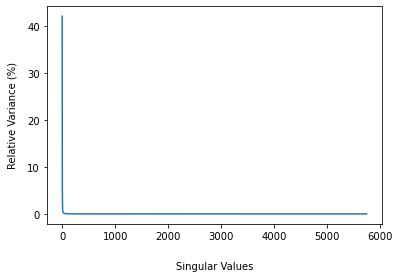

In [6]:
#possible extra
from scipy import linalg, dot

U, s, Vt = linalg.svd(plmimat)  
# Ignoring Vt
rel_variance = ( s**2 / sum(s**2) ) * 100
y_values = rel_variance
x_values = np.arange(len(y_values))

plt.plot(x_values, y_values, linestyle = '-')

plt.xlabel("Singular Values", labelpad = 20)
plt.ylabel("Relative Variance (%)", labelpad = 10)

plt.show()

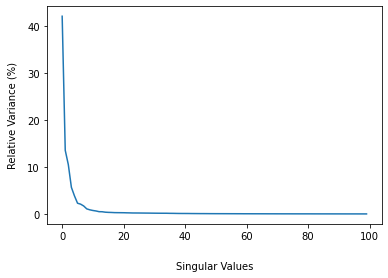

In [7]:
y_values =  rel_variance[:100] 
x_values = np.arange(len(y_values))

plt.plot(x_values, y_values, linestyle = '-')

plt.xlabel("Singular Values", labelpad = 20)
plt.ylabel("Relative Variance (%)", labelpad = 10)

plt.show()

In [8]:
dimensions = 20 #based on the plot my dimension should be around 10-20. 
                # evaluation gives a very low rating.
W = U[:, 0 : dimensions]
sigma = s[:dimensions]
C = Vt[0 : dimensions, :]

ppmimat_50 = np.dot(W, linalg.diagsvd(sigma, dimensions, len(C)))

df = pd.DataFrame(ppmimat_50)
df.head() #showing the dimensionality reduction

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.587908,-1.272614,-0.198519,0.081219,-1.049819,0.736354,0.069094,-0.453199,-0.576162,-0.512187,-1.467671,0.782910,0.323586,0.003936,1.171713,-1.153777,0.700813,-0.535616,1.964134,2.588341
1,-5.275384,-1.204054,-5.424600,-1.657403,-5.250083,0.368037,-4.537820,0.113680,-2.490579,-0.870463,-0.572572,-0.031532,-1.362388,-2.425559,-2.628291,-0.193583,-0.937371,0.371874,-0.208500,-0.281547
2,-2.829349,-1.802252,-1.242229,1.592211,-0.781203,1.992597,0.857040,2.066856,2.363373,4.001642,-1.581244,-1.899431,-0.815302,-0.457203,-1.534899,-2.369593,-0.845788,-0.606614,0.083525,1.730319
3,-13.816831,9.212942,-5.407005,-0.653507,-3.859685,2.802605,14.511081,0.981600,0.319992,-1.251823,0.526329,4.838886,-0.932805,-1.001713,1.562075,0.709313,4.847704,-1.968050,-0.956977,3.116242
4,-0.924849,-3.366784,-0.962595,-2.181574,-4.369975,1.435332,0.083679,-0.793145,-2.169962,-0.576782,-1.547163,-0.491965,-0.853832,-1.149386,0.239273,0.183790,-0.357896,-0.145645,-0.031924,0.582959


## Question 4 (20 points)

Train a Word2Vec model the same corpus, for example using [gensim](https://radimrehurek.com/gensim). Make sure to motivate the choice of your hyperparameters.

**Possible extra**

*Fine-tuning* is the process of starting from a pre-trained embedding model and training it some more using new data. Try to use a pre-trained model from gensim and to fine-tune it on the Reuters corpus.

In this question, I will make use code sections from Giovanni Colavizza's and Jelke Bloem's  Notebook's on 
Vector Semantics and Word Embeddings.

Source: https://github.com/bloemj/AUC_TMCI_2022


In [9]:
from gensim import models
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api


lemma_sentences = []
for sentence in reuters_lemmatized: #create list of lemmatized sentences to feed into model
    line = []
    for word in sentence:
        line.append(word.split("-")[0])
    lemma_sentences.append(line)

# hyperparameters from Word2Vec_FastText_Comparison
param = {
    'vector_size': 100, # I will use 100 dimensions of embeddings inorder to be able to compare it to my other models.
    'alpha': 0.12, # initial learning rate for SGD. After multiple trials this learning rate seemed to produce the best results.
    'window': 5, # window -/+ before and after traget word as in question 1.
    'min_count': 5, # filter on words whose frequency is below this count.
    'workers': 4, # number of cores on my cpu.
    'sg': 1, # To implement skip-gram to the trainig algorithm.
    'negative': 5, # noise words to be drawn for negative sampling.
    'epochs': 5 # number of iterations over the corpus.
}
model = Word2Vec(lemma_sentences, **param)
print(model)

model1 = api.load("glove-wiki-gigaword-100") #load original
model1.save_word2vec_format('gwg100.txt', binary=False) #save in txt format

model2 = Word2Vec(vector_size=100, min_count=1)
model2.build_vocab(lemma_sentences) #build with original sentences
total_examples = model2.corpus_count

model2.build_vocab([list(model1.index_to_key)], update=True) #build with vocab from model1
#model2.intersect_word2vec_format('gwg100.txt', binary=False, lockf=1.0) #intersecting the two vocabs
model2.train(lemma_sentences, total_examples=total_examples, epochs=model2.epochs)

print(model2)

Word2Vec(vocab=7803, vector_size=100, alpha=0.12)
Word2Vec(vocab=404809, vector_size=100, alpha=0.025)


In [12]:
lemma_sentences

[['asian',
  'exporter',
  'fear',
  'damage',
  'from',
  'japan',
  'rift',
  'mounting',
  'trade',
  'friction',
  'japan',
  'raise',
  'fear',
  'among',
  'many',
  'asia',
  'export',
  'nation',
  'could',
  'inflict',
  'reach',
  'economic',
  'damage',
  'businessmen',
  'official',
  'say'],
 ['they',
  'tell',
  'reuter',
  'correspondent',
  'asian',
  'capital',
  'move',
  'japan',
  'might',
  'boost',
  'protectionist',
  'sentiment',
  'lead',
  'curb',
  'american',
  'import',
  'product'],
 ['exporter',
  'say',
  'conflict',
  'would',
  'hurt',
  'long',
  'short',
  'term',
  'tokyo',
  'loss',
  'might',
  'gain'],
 ['say',
  'impose',
  'dlrs',
  'tariff',
  'import',
  'japanese',
  'electronics',
  'good',
  'april',
  'retaliation',
  'japan',
  'allege',
  'failure',
  'stick',
  'pact',
  'sell',
  'semiconductor',
  'world',
  'market',
  'cost'],
 ['unofficial',
  'japanese',
  'estimate',
  'impact',
  'tariff',
  'billion',
  'dlrs',
  'spokesman',


---

# Evaluating on semantic similarity (20 points)

## Question 5 (20 points)

Evaluate the performance of your models on a **semantic similarity task**. Using `SimLex-999` as gold standard. Evaluate all of your models on the dataset in `data/SimLex-999.txt`, and determine the best performing model. Note: There should be 5 to 8 model evaluations in total. 5 if you did not do any extra (2 from 4.1 + 2 from 4.2 + 1 from 4.3), and 8 if you did them all (3 from 4.1 + 3 from 4.2 + 2 from 4.3).

1. Your evaluation should follow the approach shown in lab 4 (Section 1.6: "Evaluating your Model"), using a **correlation measure** on model predictions and the (human) gold standard. 
2. Remember to **visualize** your results (e.g., as bar plots).
3. Take note (and report) the overlap between your models and the SimLex-999 dataset, i.e., how many pairs are shared by your model and the evaluation dataset.
4. Make sure to discuss your results and provide your reasoning on them.

### Remarks

- The 'SimLex-999' dataset is described in `data/SimLex-999.README.txt`, and [the author's github page](https://fh295.github.io/simlex.html). Hint: the relevant judgements are those in the `SimLex999` column.
- To directly compare the models against the gold standard, you will have to find the *overlap* between them, i.e. the pairs that occur in your model *and* the evaluation dataset.

In this question, I will make use code sections from Giovanni Colavizza's and Jelke Bloem's  Notebook's on 
Vector Semantics and Word Embeddings.

Source: https://github.com/bloemj/AUC_TMCI_2022

In [4]:
nouns= []
for word, p in vector_indices.items():
    nouns.append(word.split("-")[0]) #list of only nouns without pos tag


lst_items=[]    
simLex_999 = dict()    
with open("data/SimLex-999.txt") as f:
    for i, line in enumerate(f.read().split("\n")):
        items = line.split("\t")
        lst_items.append(items)
        if (lst_items[i][0] in nouns and lst_items[i][1] in nouns):
                w1 = items[0] + "-NOUN" #I chose nouns as my target vectors again.
                w2 = items[1] + "-NOUN" 
                simLex_999[(w1, w2)] = float(lst_items[i][4])
                

NameError: name 'vector_indices' is not defined

In [11]:
bam_pmi_sim_mat = sklearn.metrics.pairwise.cosine_similarity(pmimat)
plmi_sim_mat = sklearn.metrics.pairwise.cosine_similarity(plmimat)
smoothppmi_sim_mat = sklearn.metrics.pairwise.cosine_similarity(smoothedppmimat)

bam_pmi_trunk_sim_mat = sklearn.metrics.pairwise.cosine_similarity(bam_pmimat_100)
plmi_trunk_sim_mat = sklearn.metrics.pairwise.cosine_similarity(plmimat_100)
smoothppmi_trunk_sim_mat = sklearn.metrics.pairwise.cosine_similarity(smoothedppmimat_100)


measure2mat = {"bam.pmi": bam_pmi_sim_mat, "bam-100": bam_pmi_trunk_sim_mat, "positiveLMI": plmi_sim_mat,
               "plmi-100" : plmi_trunk_sim_mat, "sppmi" : smoothppmi_sim_mat, "sppmi-100" : smoothppmi_trunk_sim_mat}

rhos = []
measures = []

for m, mat in measure2mat.items():
    
    wordsim_ratings = []
    vsm_sims = []
    for (w1, w2), r in simLex_999.items():
        w1idx = vector_indices[w1]
        w2idx = vector_indices[w2]
        wordsim_ratings.append(r)
        vsm_sims.append(mat[w1idx, w2idx])
        
    rho, pval = scipy.stats.spearmanr(wordsim_ratings, vsm_sims)   
    rhos.append(rho)
    print(m, rho)
    measures.append(m)

MemoryError: Unable to allocate 2.73 GiB for an array with shape (19150, 19150) and data type float64

In [2]:
wordSim_ratings = []
vsm_sims = []
counting = 0
for line in lst_items:
    if len(line) > 1:
        word1 = line[0]
        word2 = line[1]
        pos = line[2]
        value = line[3]

        if word1 in model.wv.index_to_key and word2 in model.wv.index_to_key and pos == "N":
            counting = counting + 1
            wordSim_ratings.append(float(value))
            vsm_sims.append(model.wv.similarity(word1, word2))


rho, pval = scipy.stats.spearmanr(wordSim_ratings, vsm_sims)
print("word2vec", rho)
rhos.append(rho)
measures.append("word2vec")


NameError: name 'lst_items' is not defined

In [3]:
wordSim_ratings = []
vsm_sims = []
counting2 = 0
for line in lst_items:
    if len(line) > 1:
        word1 = line[0]
        word2 = line[1]
        pos = line[2]
        value = line[3]

        if word1 in model2.wv.index_to_key and word2 in model2.wv.index_to_key and pos == "N":
            counting2 = counting2 + 1
            wordSim_ratings.append(float(value))
            vsm_sims.append(model2.wv.similarity(word1, word2))


rho, pval = scipy.stats.spearmanr(wordSim_ratings, vsm_sims)
print("pretrained word2vec", rho)
rhos.append(rho)
measures.append("word2vec2")

plt.bar(range(0, len(rhos)), rhos)
plt.xticks(range(0, len(rhos)), measures, size='small')
plt.show()

NameError: name 'lst_items' is not defined

It is expected that Bam_PMI and PLMI have a lower spearman scores than BAM-100 and plmi-100 as they have lower dimensions.
Surprisingly, Bam_PMI is larger than PLMI although Plmi should have added increased weighting to word-context pairs with higher frequencies.
It is also surprising that the sppmi performs worse than bam.pmi since it should tackle PPMIs bias towards co-occurrences of rare words. 
The Word2vec models outperform the rest. 

---